In [1]:
# uses a lot from this tutorial on image classification with Tensorflow:
#           https://www.tensorflow.org/tutorials/images/classification

In [2]:
import sys
print(sys.executable)

C:\Users\thoma\miniconda3\envs\elden\python.exe


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from IPython.display import display
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Do we find GPU?
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Are we using GPU`?
tf.test.is_built_with_cuda()

True

In [5]:
# path to image dataset (created with the notebook "createImages.ipynb")
data_dir = Path() / 'elden_ring_death_dataset'
data_dir.exists()

True

In [6]:
# show classes
for class_folder in data_dir.iterdir():
    n_images = len(list(class_folder.glob('*.png')))
    print(f'{class_folder.stem:<10} {n_images} images')

death      100 images
non-death  900 images


Example of death:


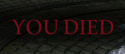

Example of non-death:


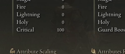

In [7]:
full_death_img_paths = list(data_dir.glob('death/*.png'))
full_nondeath_img_paths = list(data_dir.glob('non-death/*.png'))

# shuffle them
np.random.shuffle(full_death_img_paths)
np.random.shuffle(full_nondeath_img_paths)

# retain some for evaluation after training 
#  (not retained set will split further into train/validation set)
left_out_ratio = 0.2
left_out_death_slice_ix = int(left_out_ratio * len(full_death_img_paths))
left_out_nondeath_slice_ix = int(left_out_ratio * len(full_nondeath_img_paths))
# the files we keep for after training
left_out_death_img_paths = full_death_img_paths[:left_out_death_slice_ix]
left_out_nondeath_img_paths = full_nondeath_img_paths[:left_out_nondeath_slice_ix]

# the files we use for training and validation
death_img_paths = full_death_img_paths[left_out_death_slice_ix:]
nondeath_img_paths = full_nondeath_img_paths[left_out_nondeath_slice_ix:]

demo_death_img = PIL.Image.open(np.random.choice(death_img_paths))
demo_nondeath_img = PIL.Image.open(np.random.choice(nondeath_img_paths))

print('Example of death:')
display(demo_death_img)

print('Example of non-death:')
display(demo_nondeath_img)

In [8]:
len(left_out_death_img_paths), len(left_out_nondeath_img_paths)

(20, 180)

In [9]:
len(death_img_paths), len(nondeath_img_paths)

(80, 720)

In [10]:
# Set some params
batch_size = 32

# get dimensions of images
img_width, img_height = demo_death_img.size
img_width, img_height

(125, 54)

In [11]:
# create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [12]:
# create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['death', 'non-death']


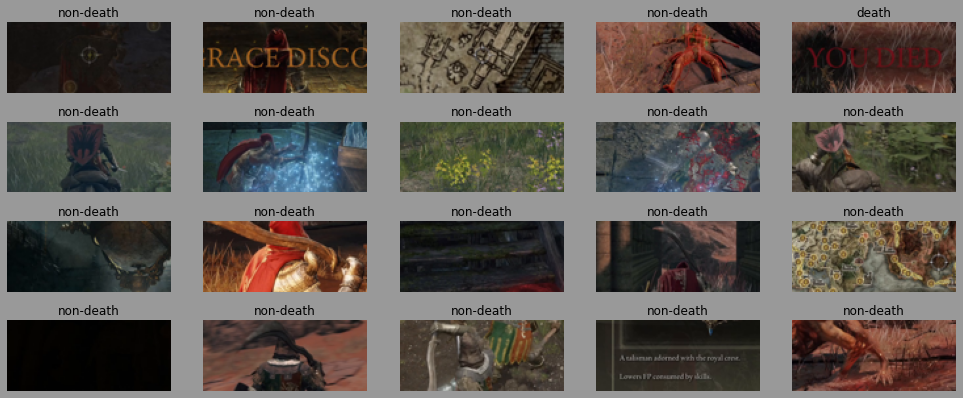

In [14]:
# taking a look at the data
plt.figure(figsize=(17, 7), facecolor='#999')
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# look at what a batch looks like
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 54, 125, 3)
(32,)


In [16]:
# read more about tuning and caching from performance:
#   https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
#   https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu'),
  layers.Dropout(0.05),
  layers.Dense(num_classes)
])

In [18]:
# could also try binary ce
#loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# compile model with loss and metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = ['accuracy', tf.keras.metrics.Precision()]
metrics = ['accuracy']
#metrics = [tf.keras.metrics.Precision()]

model.compile(optimizer='adam',
              loss=loss_object,
              metrics=metrics)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 54, 125, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 54, 125, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 62, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 31, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12896)             0

In [20]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
25/25 [==============================] - 3s 11ms/step - loss: 0.2453 - accuracy: 0.8825 - val_loss: 0.1734 - val_accuracy: 0.8800
Epoch 2/25
25/25 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.9513 - val_loss: 0.0725 - val_accuracy: 0.9950
Epoch 3/25
25/25 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.9862 - val_loss: 0.0421 - val_accuracy: 0.9900
Epoch 4/25
25/25 [==============================] - 0s 4ms/step - loss: 0.0268 - accuracy: 0.9925 - val_loss: 0.0157 - val_accuracy: 0.9950
Epoch 5/25
25/25 [==============================] - 0s 4ms/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 6/25
25/25 [==============================] - 0s 4ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 7/25
25/25 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.0125 - val_accuracy: 0.9950
Epoch 8/25
25/25 [=

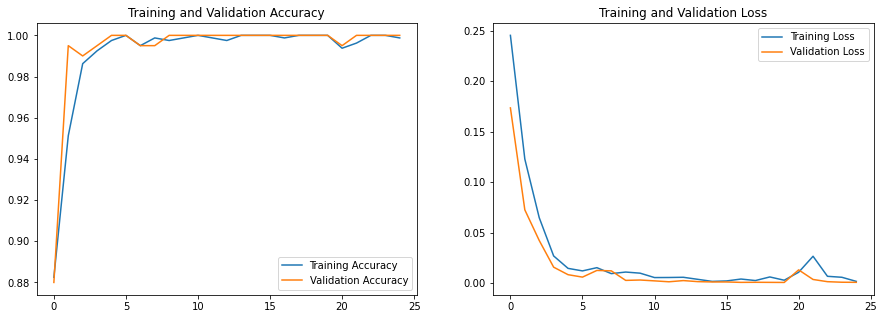

In [21]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# inform about unsafe use of models from strangers
#   https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md
#

In [23]:
# save model to a file
models_file_path = Path() / 'models'
models_file_path.mkdir(parents=True, exist_ok=True)

model.save(models_file_path / 'theModel')


INFO:tensorflow:Assets written to: models\theModel\assets


In [24]:
# random death
random_death = np.random.choice(death_img_paths)


In [25]:
# get np array of imgs
def paths_to_array(paths):
    return np.array([np.array(PIL.Image.open(f)) for f in paths])

# use model to predict / classify new frame
def classify_image(img_file):
    img = tf.keras.utils.load_img(
        img_file, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    print(f'img array shape {img_array.shape}')
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    print(f'img array expanded shape {img_array.shape}')
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    display(PIL.Image.open(img_file))
    return class_names[np.argmax(score)], np.max(score)

img array shape (54, 125, 3)
img array expanded shape (1, 54, 125, 3)
This image most likely belongs to death with a 99.99 percent confidence.


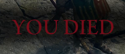

('death', 0.9999423)

In [26]:
classify_image(death_img_paths[0])

In [27]:
img_array = paths_to_array(death_img_paths)
img_array.shape

(80, 54, 125, 3)

In [28]:
def plot_file_list(paths):
    # run prediction on a list of image files
    img_array = paths_to_array(paths)
    #img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)

    # iterate files to visualize predictions in figure
    plt.figure(figsize=(17, 35), facecolor='#999')
    for i, img_path in enumerate(paths):
        if i >= 100:
            # only plot 100 images
            break
        # read predicted class name and its score from predictions
        scores = tf.nn.softmax(predictions[i])
        score = np.max(scores)
        class_name = class_names[np.argmax(scores)]    
        # add image and prediction to plot
        ax = plt.subplot(20, 5, i + 1)
        plt.imshow(np.array(PIL.Image.open(img_path)).astype("uint8"))
        plt.title(f'{class_name}   {score * 100:.2f}')
        plt.axis("off")

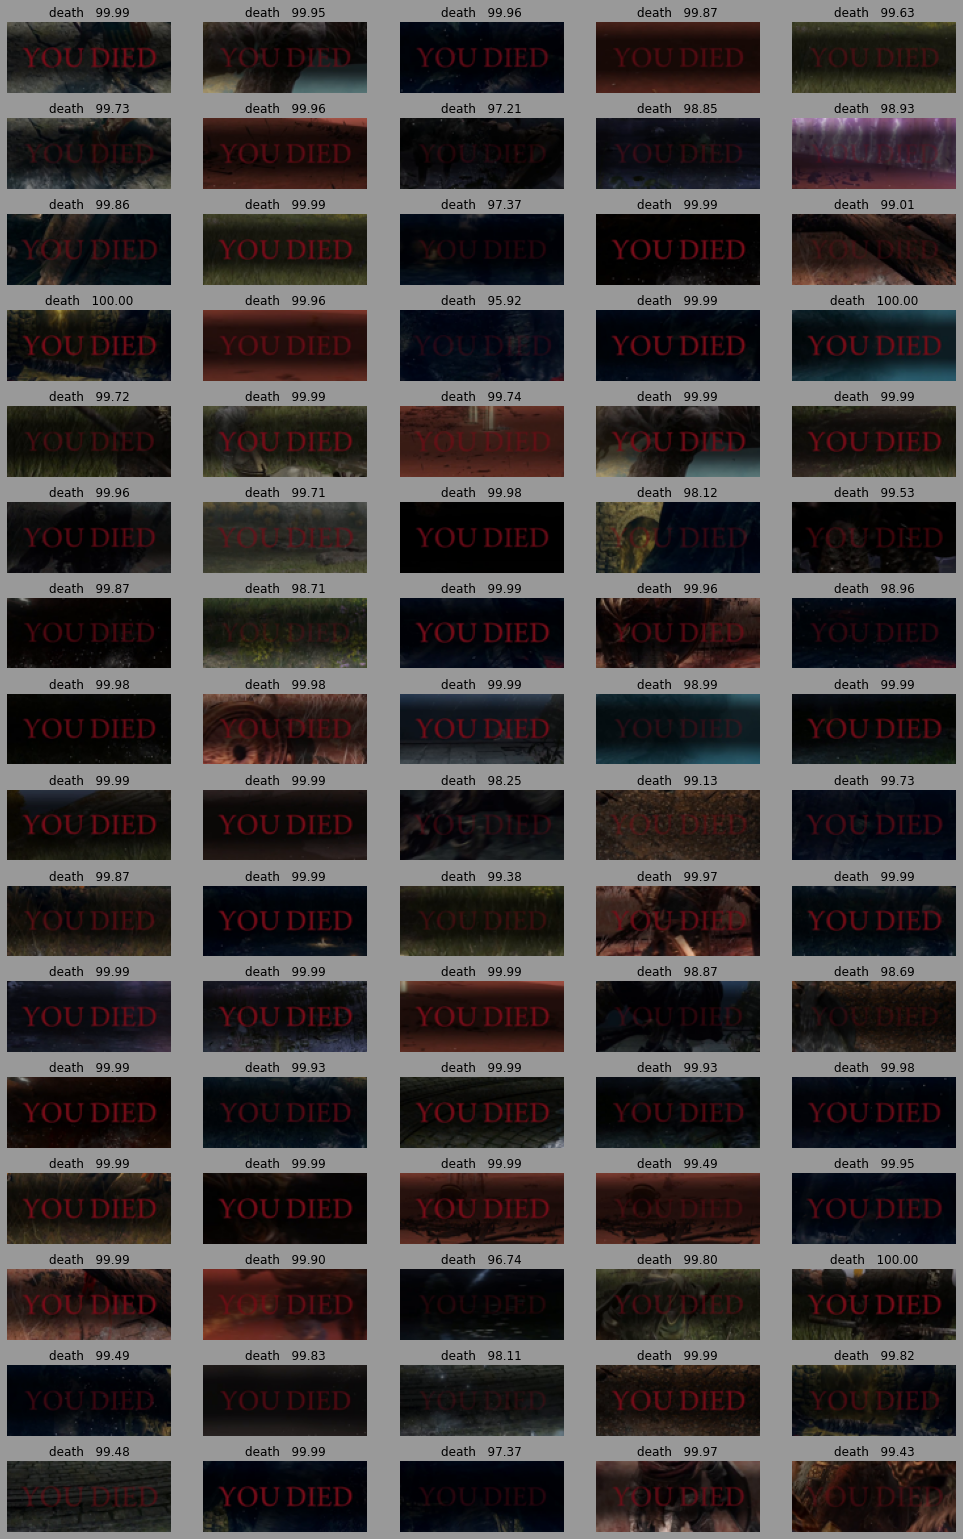

In [29]:
plot_file_list(death_img_paths)

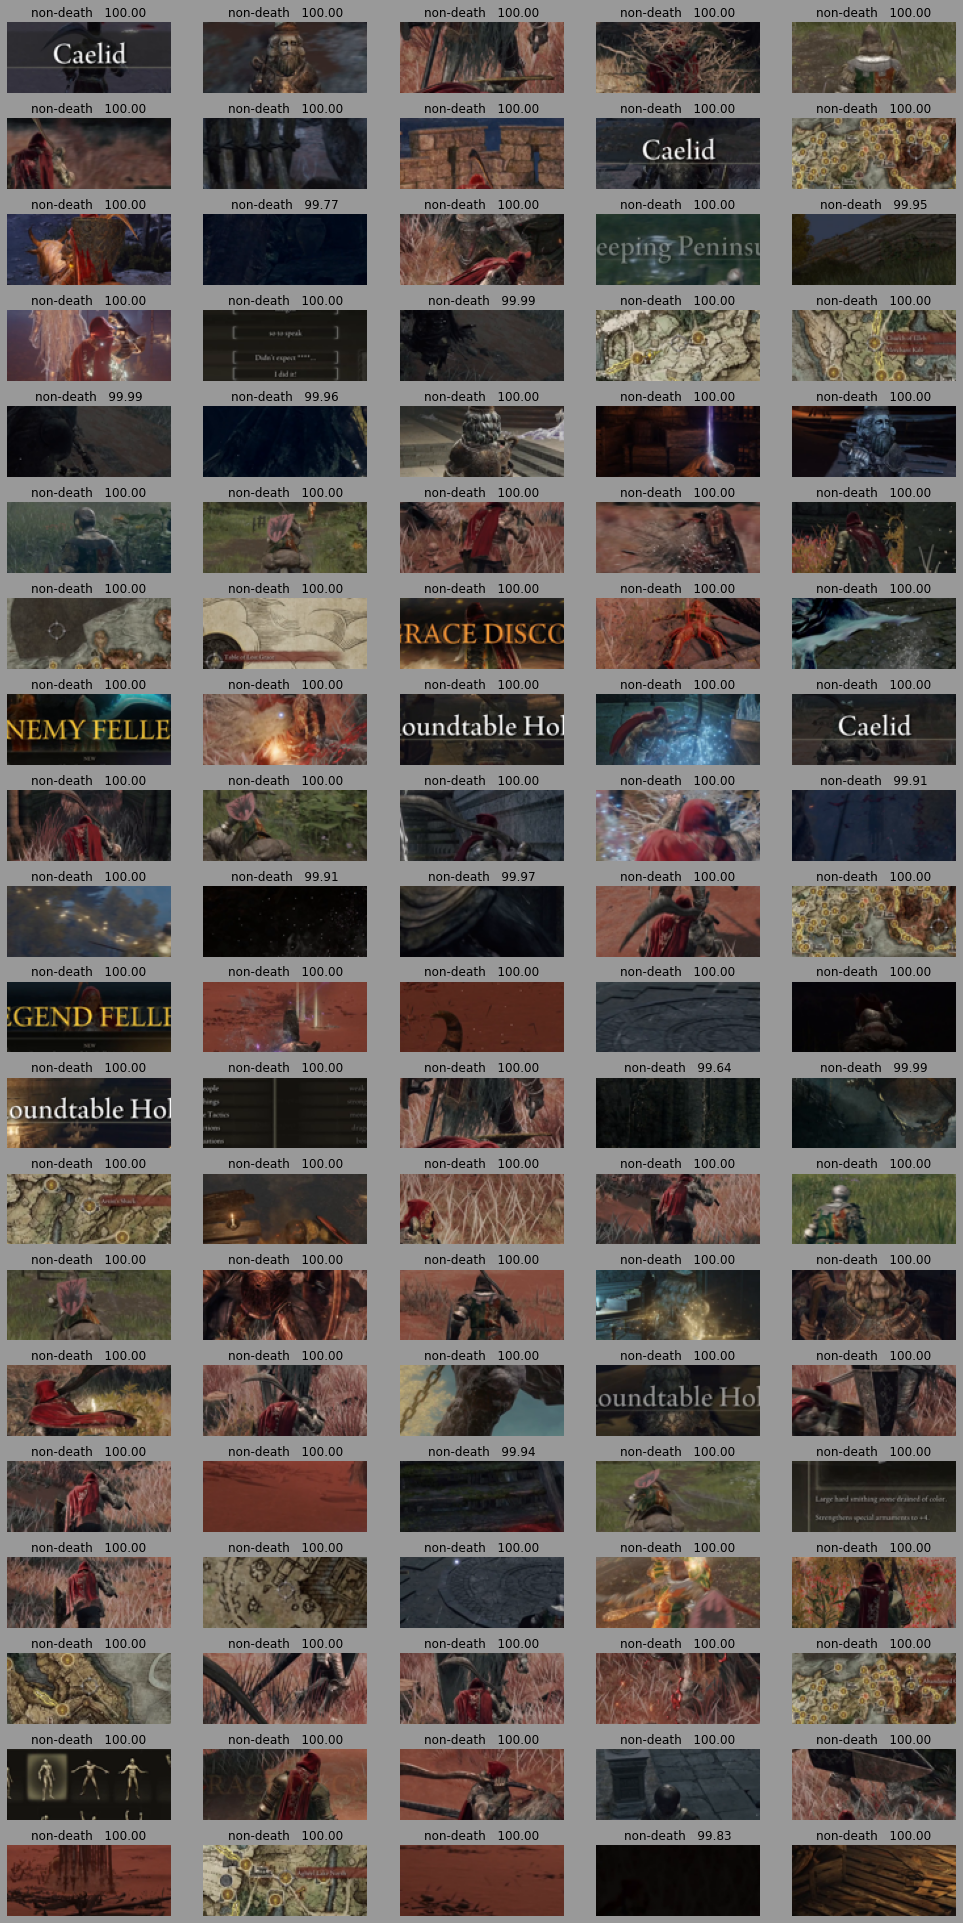

In [30]:
plot_file_list(np.random.choice(nondeath_img_paths, size=100, replace=False))

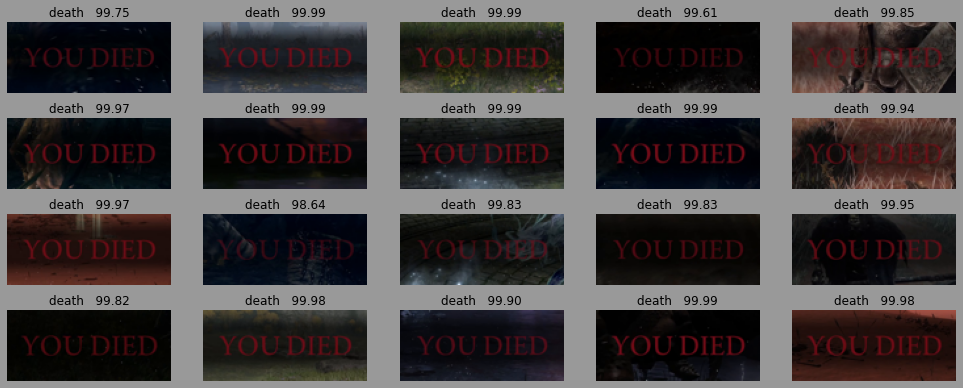

In [31]:
plot_file_list(left_out_death_img_paths)

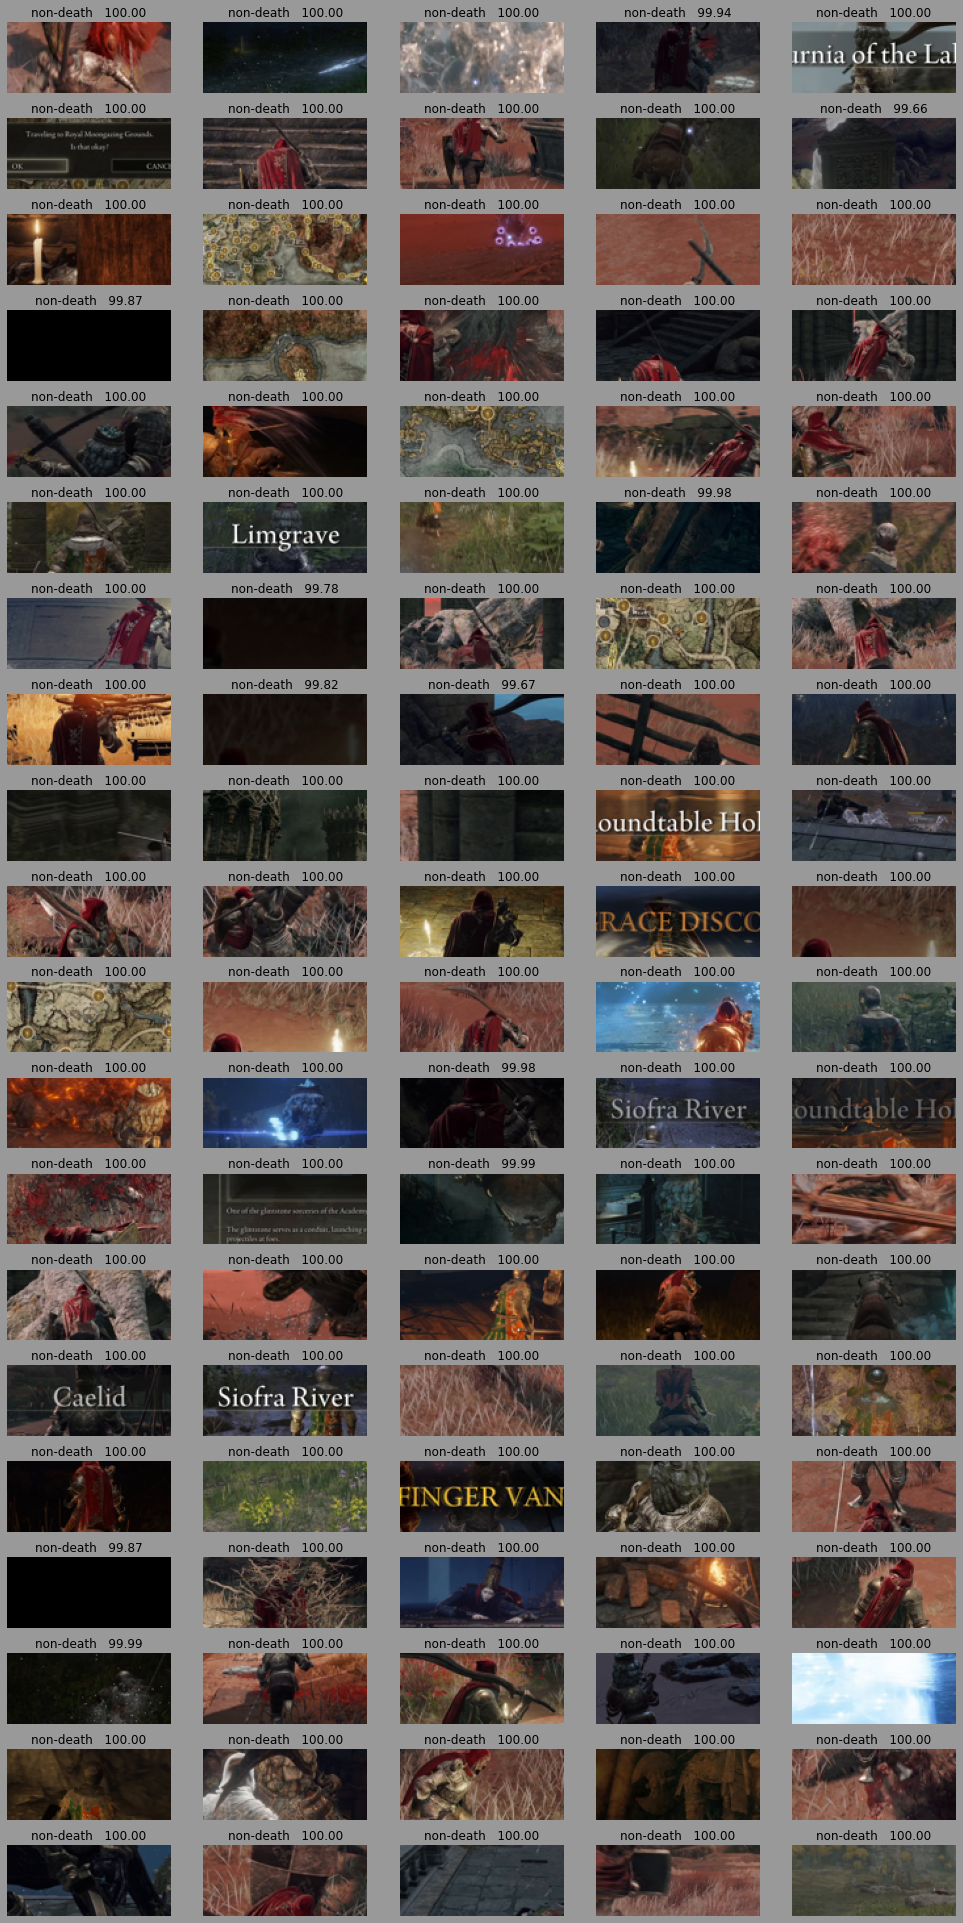

In [32]:
plot_file_list(np.random.choice(left_out_nondeath_img_paths, size=100, replace=False))

In [31]:
# Sources:
#  https://kidadl.com/quotes/inspiring-proverbs-quotes-the-wisest-words-to-live-by
#  https://www.shopify.com/blog/motivational-quotes

proverbs = [
    "He who asks is a fool for five minutes, but he who does not ask remains a fool forever.",
    "Give a man a fish and you feed him for a day. Teach a man to fish and you feed him for a lifetime.",
    "Do not desire to hurt others in the depths of your heart.",
    "When reading, don’t let a single word escape your attention; one word may be worth a thousand pieces of gold.",
    "Blame yourself as you blame others; forgive others as you forgive yourself.",
    "A bird does not sing because it has an answer. It sings because it has a song.",
    "Once one is a teacher, one becomes a parent for life.",
    "An inch of time is an inch of gold but you can't buy that inch of time with an inch of gold.",
    "One who is wise enough to secure the good of others has secured his own.",
    "A smile will gain you ten more years of life.",
    "The only thing we should be afraid of is stopping completely.",
    "Don’t listen to what they say. Go see.",
    "Wise men may be learned. Learned men may not be wise.",
    "A man who cannot tolerate small misfortunes can never accomplish great things.",
    "Pearls don’t lie on the seashore. If you want one, you must dive for it.",
    "You will reach your destination even though you travel slowly.",
    "Better it is to have a lower position in life and be free than to have a position of power only to be subject to the will of another.",
    "Age makes many a man whiter, but not better.",
    "When men meet foes in fight, better is stout heart than sharp sword.",
    "The way you make your bed, is the way you shall lie.",
    "Mediocrity is climbing molehills without sweating.",
    "A wound never heals so well that the scar cannot be seen.",
    "If a man knew where he would fall, he would spread straw there first.",
    "You can give a piece of advice, but not good luck along with it.",
    "It’s too late to shut the stable door after the horse has bolted.",
    "Wrath often consumes what God gives husbands.",
    "If a blind man leads another, they both fall together.",
    "He is little suited to be a baker, whose head is made of butter.",
    "Too much ale and a man’s heart is laid open for all to see.",
    "Short is the life of the proud.",
    "Not to feel one’s misfortunes is not human, not to bear them is not manly.",
    "Where there are two friends with one purse, one sings, the other weeps.",
    "One fool may ask more questions than seven wise men can answer.",
    "A danger foreseen is half avoided.",
    "Rather have a little one for your friend, than a great one for your enemy.",
    "Tell your friend your secret, and he will set his foot on your neck.",
    "Woe to the stranger when trouble comes, for there will be no friend to take his part.",
    "The best things in life are free.",
    "Beware of an oak, it draws the stroke; avoid an ash, it counts the flash; creep under the thorn, it can save you from harm.",
    "A sheep’s bite is never more than skin deep.",
    "Nothing looks more like a man of sense than a fool who holds his tongue.",
    "By blackening another you do not whiten yourself.",
    "Throwing your cap at a bird is not the way to catch it.",
    "Speaking without thought is like shooting without taking aim.",
    "Speak well of your friend; of your enemy, neither well nor ill.",
    "It is no excuse for sin if we have sinned for the sake of a friend.",
    "A lazy shepherd is a wolf’s friend.",
    "Prosperity comes through vigilance, energy, and wise counsel.",
    "In times of prosperity friends will be plenty, in times of adversity, not one in twenty.",
    "One has always strength enough to bear the misfortunes of one’s friends.",
    "Surely the worth of a man lies in two of his smallest parts – his heart and his tongue.",
    "The rain is not a friend to anyone, whether rich or poor, good or evil.",
    "Three things in the world worth having: courage, good sense, caution.",
    "A proud heart can survive a general failure because such a failure does not prick its pride.",
    "The old woman looks after the child to grow its teeth and the young one, in turn, looks after the old woman when she loses her teeth.",
    "A family is like a forest, when you are outside it is dense, when you are inside you see that each tree has its place.",
    "Crawling on hands and knees has never prevented anyone from walking upright.",
    "As soon as the monkey has climbed a tree, it will start abusing from its elevated position.",
    "A child’s lie is like a dead fish in a pond that in the end, always comes to the surface, explains his mother.",
    "A man’s greatest support is not the gods but his own two arms.",
    "A man in this world without learning is as a beast of the field.",
    "He who has knowledge has power.",
    "Labor is bitter but the bread it buys is sweet.",
    "If you forsake a certainty and depend on an uncertainty, you will lose both the certainty and the uncertainty.",
    "Those who know do not speak, those who speak do not know.",
    "You can often find in a river what you cannot find in the ocean.",
    "When you’re thirsty it’s too late to think about digging a well.",
    "Life is not a series of pleasant choices, but of problems that call for strength, determination, and hard work.",
    "Once I had strength but no wisdom; now I have wisdom but no strength.",
    "The fear of the Lord is hatred of evil. Pride and arrogance and the way of evil and perverted speech I hate.",
    "Whoever oppresses a poor man insults his Maker, but he who is generous to the needy honors him.",
    "Fret not yourself because of evildoers, and be not envious of the wicked, for the evil man has no future; the lamp of the wicked will be put out.",
    "Whoever brings blessing will be enriched, and one who waters will himself be watered.",
    "One who is full loathes honey, but to one who is hungry, everything bitter is sweet.",
    "Like a muddied spring or a polluted fountain is a righteous man who gives way before the wicked.",
    "Open your mouth for the mute, for the rights of all who are destitute. Open your mouth, judge righteously, defend the rights of the poor and needy.",
    "My son, do not despise the Lord’s discipline or be weary of his reproof, for the Lord reproves him whom he loves, as a father the son in whom he delights.",
    "Whoever is slow to anger is better than the mighty, and he who rules his spirit than he who takes a city.",
    "All the days of the afflicted are evil, but the cheerful of heart has a continual feast.",
    "Whoever works his land will have plenty of bread, but he who follows worthless pursuits lacks sense.",
    "Gracious words are like a honeycomb, sweetness to the soul and health to the body.",
    "The fear of the Lord is the beginning of knowledge; fools despise wisdom and instruction.",
    "Rescue those who are being taken away to death; hold back those who are stumbling to the slaughter.",
    "Death and life are in the power of the tongue, and those who love it will eat its fruits.",
    "When words are many, transgression is not lacking, but whoever restrains his lips is prudent.",
    "Do not wear yourself out to get rich; have the wisdom to show restraint. Cast but a glance at riches, and they are gone, for they will surely sprout wings and fly off to the sky like an eagle.",
    "Whoever walks in integrity walks securely, but he who makes his ways crooked will be found out.",
    "There is one whose rash words are like sword thrusts, but the tongue of the wise brings healing.",
    "A man without self-control is like a city broken into and left without walls.",
    "The same dog that bit you in the morning will bite you in the evening.",
    "He who never visits your home does not want you to visit his.",
    "If you go to bed without supper, you will rise without having slept.",
    "The hunter does not rub himself in oil and lie by the fire to sleep.",
    "The chameleon changes color to match the earth; the earth doesn’t change color to match the chameleon.",
    "Tell me and I’ll forget; show me, and I may not remember; involve me, and I’ll learn.",
    "Do not wrong or hate your neighbor for it is not he that you wrong but yourself.",
    "Some people put the best outside, some keep the best inside.",
    "Don’t be too sweet lest you be eaten up; don’t be too bitter lest you be spewed out.",
    "Turn your face to the sun and the shadows fall behind you.",
    "The one who cares for the tree must also care for its branches.",
] + [   
    "Success is not final; failure is not fatal: It is the courage to continue that counts.",
    "It is better to fail in originality than to succeed in imitation.",
    "The road to success and the road to failure are almost exactly the same.",
    "Success usually comes to those who are too busy looking for it.",
    "Develop success from failures. Discouragement and failure are two of the surest stepping stones to success.",
    "Nothing in the world can take the place of Persistence. Talent will not; nothing is more common than unsuccessful men with talent. Genius will not; unrewarded genius is almost a proverb. Education will not; the world is full of educated derelicts. The slogan 'Press On' has solved and always will solve the problems of the human race.",
    "There are three ways to ultimate success: The first way is to be kind. The second way is to be kind. The third way is to be kind.",
    "Success is peace of mind, which is a direct result of self-satisfaction in knowing you made the effort to become the best of which you are capable.",
    "I never dreamed about success. I worked for it.",
    "Success is getting what you want, happiness is wanting what you get."
] + [
    "The pessimist sees difficulty in every opportunity. The optimist sees opportunity in every difficulty.",
    "Don’t let yesterday take up too much of today.",
    "You learn more from failure than from success. Don’t let it stop you. Failure builds character.",
    "If you are working on something that you really care about, you don’t have to be pushed. The vision pulls you."
] + [
    "Experience is a hard teacher because she gives the test first, the lesson afterwards.",
    "To know how much there is to know is the beginning of learning to live.",
    "Goal setting is the secret to a compelling future."
] + [
    "Concentrate all your thoughts upon the work in hand. The sun's rays do not burn until brought to a focus. ",
    "Either you run the day or the day runs you.",
    "I’m a greater believer in luck, and I find the harder I work the more I have of it.",
    "When we strive to become better than we are, everything around us becomes better too.",
    "Opportunity is missed by most people because it is dressed in overalls and looks like work.",
    "Setting goals is the first step in turning the invisible into the visible.",
    "Your work is going to fill a large part of your life, and the only way to be truly satisfied is to do what you believe is great work. And the only way to do great work is to love what you do. If you haven't found it yet, keep looking. Don't settle. As with all matters of the heart, you'll know when you find it.",
    "It’s not about better time management. It’s about better life management"
] + [
    "The elevator to success is out of order. You’ll have to use the stairs, one step at a time.",
    "Be a positive energy trampoline – absorb what you need and rebound more back.",
    "People often say that motivation doesn’t last. Well, neither does bathing – that’s why we recommend it daily.",
    "Work until your bank account looks like a phone number.",
    "I am so clever that sometimes I don’t understand a single word of what I am saying.",
    "People say nothing is impossible, but I do nothing every day.",
    "Life is like a sewer… what you get out of it depends on what you put into it.",
    "I always wanted to be somebody, but now I realise I should have been more specific."
] + [
    "Just one small positive thought in the morning can change your whole day.",
    "Opportunities don't happen, you create them.",
    "Love your family, work super hard, live your passion.",
    "It is never too late to be what you might have been.",
    "Don't let someone else's opinion of you become your reality",
    "If you’re not positive energy, you’re negative energy.",
    "I am not a product of my circumstances. I am a product of my decisions."
] + [
    "The greatest discovery of my generation is that a human being can alter his life by altering his attitudes.",
    "One of the differences between some successful and unsuccessful people is that one group is full of doers, while the other is full of wishers.",
    "I’d rather regret the things I’ve done than regret the things I haven’t done.",
    "You cannot plow a field by turning it over in your mind. To begin, begin.",
    "When you arise in the morning think of what a privilege it is to be alive, to think, to enjoy, to love…",
    "Mondays are the start of the work week which offer new beginnings 52 times a year!",
    "Be miserable. Or motivate yourself. Whatever has to be done, it's always your choice.",
    "Your Monday morning thoughts set the tone for your whole week. See yourself getting stronger, and living a fulfilling, happier &amp; healthier life."
] + [
    "You can get everything in life you want if you will just help enough other people get what they want.",
    "Inspiration does exist, but it must find you working.",
    "Don't settle for average. Bring your best to the moment. Then, whether it fails or succeeds, at least you know you gave all you had.",
    "Show up, show up, show up, and after a while the muse shows up, too.",
    "Don't bunt. Aim out of the ballpark. Aim for the company of immortals.",
    "I have stood on a mountain of no’s for one yes.",
    "If you believe something needs to exist, if it's something you want to use yourself, don't let anyone ever stop you from doing it."
] + [
    "Don't look at your feet to see if you are doing it right. Just dance.",
    "Someone's sitting in the shade today because someone planted a tree a long time ago.",
    "True freedom is impossible without a mind made free by discipline.",
    "Rivers know this: there is no hurry. We shall get there some day.",
    "There is a vitality, a life force, an energy, a quickening that is translated through you into action, and because there is only one of you in all time, this expression is unique. And if you block it, it will never exist through any other medium and will be lost.",
    "Small is not just a stepping-stone. Small is a great destination itself.",
    "He that can have patience can have what he will.",
    "The only one who can tell you “you can’t win” is you and you don’t have to listen.",
    "Set your goals high, and don’t stop till you get there.",
    "Take your victories, whatever they may be, cherish them, use them, but don’t settle for them."
] + [
    "Life can be much broader once you discover one simple fact: Everything around you that you call life was made up by people that were no smarter than you. And you can change it, you can influence it… Once you learn that, you'll never be the same again.",
    "Life is like riding a bicycle. To keep your balance you must keep moving.",
    "What you do speaks so loudly that I cannot hear what you say.",
    "I have never let my schooling interfere with my education.",
    "If you can't yet do great things, do small things in a great way.",
    "If you really want to do something, you'll find a way. If you don't, you'll find an excuse.",
    "Be sure you put your feet in the right place, then stand firm.",
    "Live out of your imagination, not your history.",
    "Do not wait for the perfect time and place to enter, for you are already onstage.",
    "The greater the difficulty, the more the glory in surmounting it.",
    "I will try again tomorrow.",
    "If the decisions you make about where you invest your blood, sweat, and tears are not consistent with the person you aspire to be, you’ll never become that person."
] + [
    "Fear of what other people will think is the single most paralyzing dynamic in business and in life. The best moment of my life was the day I realized that I no longer give a damn what anybody thinks. That’s enormously liberating and freeing, and it’s the only way to live your life and do your business",
    "The only way of discovering the limits of the possible is to venture a little way past them into the impossible.",
    "Worry is a misuse of imagination.",
    "Courage is the most important of all the virtues because without courage, you can't practice any other virtue consistently.",
    "I never look back, darling. It distracts from the now.",
    "A year from now you will wish you had started today.",
    "The reason we struggle with insecurity is because we compare our behind-the-scenes with everyone else’s highlight reel.",
    "Somewhere, something incredible is waiting to be known.",
    "I will not lose, for even in defeat, there’s a valuable lesson learned, so it evens up for me.",
    "I do not try to dance better than anyone else. I only try to dance better than myself.",
    "If you don’t risk anything, you risk even more."
] + [
    "Failure is simply the opportunity to begin again, this time more intelligently.",
    "Our greatest glory is not in never falling, but in rising every time we fall.",
    "If you change the way you look at things, the things you look at change.",
    "We must reach out our hand in friendship and dignity both to those who would befriend us and those who would be our enemy.",
    "It's fine to celebrate success but it is more important to heed the lessons of failure."
] + [
    "We need to accept that we won’t always make the right decisions, that we’ll screw up royally sometimes – understanding that failure is not the opposite of success, it’s part of success.",
    "When everything seems to be going against you, remember that the airplane takes off against the wind, not with it.",
    "You cannot always control what goes on outside. But you can always control what goes on inside.",
    "We are what we repeatedly do. Excellence, then, is not an act, but a habit.",
    "Start where you are. Use what you have. Do what you can.",
    "Hustle beats talent when talent doesn’t hustle"
] + [
    "Make sure your worst enemy doesn’t live between your own two ears.",
    "It is a rough road that leads to the heights of greatness.",
    "For the great doesn’t happen through impulse alone, and is a succession of little things that are brought together.",
    "If we take care of the moments, the years will take care of themselves.",
    "Resilience is when you address uncertainty with flexibility.",
    "Sometimes magic is just someone spending more time on something than anyone else might reasonably expect.",
    "It’s not the will to win that matters—everyone has that. It’s the will to prepare to win that matters.",
    "As a single footstep will not make a path on the earth, so a single thought will not make a pathway in the mind. To make a deep physical path, we walk again and again. To make a deep mental path, we must think over and over the kind of thoughts we wish to dominate our lives.",
    "Never give up on a dream just because of the time it will take to accomplish it. The time will pass anyway.",
    "True humility is not thinking less of yourself; it is thinking of yourself less."
] + [
    "The two most important days in your life are the day you’re born and the day you find out why.",
    "Nothing ever goes away until it teaches us what we need to know.",
    "First forget inspiration. Habit is more dependable. Habit will sustain you whether you're inspired or not. Habit will help you finish and polish your stories. Inspiration won't. Habit is persistence in practice.",
    "The battles that count aren't the ones for gold medals. The struggles within yourself—the invisible, inevitable battles inside all of us—that's where it's at.",
    "If there is no struggle, there is no progress.",
    "Courage is like a muscle. We strengthen it by use.",
    "Relentlessly prune bullshit, don't wait to do things that matter, and savor the time you have. That's what you do when life is short.",
    "More is lost by indecision than wrong decision.",
    "If the highest aim of a captain were to preserve his ship, he would keep it in port forever.",
    "You can be the ripest, juiciest peach in the world, and there's still going to be somebody who hates peaches.",
    "Keep a little fire burning; however small, however hidden."
] + [
    "I think it’s intoxicating when somebody is so unapologetically who they are.",
    "You can never leave footprints that last if you are always walking on tiptoe.",
    "If you don’t like the road you’re walking, start paving another one.",
    "If it makes you nervous, you’re doing it right.",
    "What you do makes a difference, and you have to decide what kind of difference you want to make.",
    "I choose to make the rest of my life the best of my life.",
    "In order to be irreplaceable one must always be different.",
    "Anything can make me stop and look and wonder, and sometimes learn.",
    "People's passion and desire for authenticity is strong.",
    "A surplus of effort could overcome a deficit of confidence.",
    "Doubt is a killer. You just have to know who you are and what you stand for.",
    "No one changes the world who isn’t obsessed.",
    "I learned a long time ago that there is something worse than missing the goal, and that’s not pulling the trigger.",
    "Some people want it to happen, some wish it would happen, others make it happen."
] + [
    "It is remarkable how much long-term advantage people like us have gotten by trying to be consistently not stupid, instead of trying to be very intelligent.",
    "You can’t be that kid standing at the top of the waterslide, overthinking it. You have to go down the chute.",
    "When I believe in something, I’m like a dog with a bone.",
    "And the day came when the risk to remain tight in a bud was more painful than the risk it took to blossom.",
    "The standard you walk past, is the standard you accept.",
    "I've searched all the parks in all the cities and found no statues of committees.",
    "Success is stumbling from failure to failure with no loss of enthusiasm.",
    "Keep your eyes on the stars, and your feet on the ground.",
    "Do not stop thinking of life as an adventure. You have no security unless you can live bravely, excitingly, imaginatively; unless you can choose a challenge instead of competence.",
    "Perfection is not attainable. But if we chase perfection we can catch excellence.",
    "Get a good idea and stay with it. Dog it, and work at it until it’s done right.",
    "Optimism is the faith that leads to achievement. Nothing can be done without hope and confidence."
]

print(f'We have {len(proverbs)} inspirational and/or motivational quotes!')

We have 246 inspirational and/or motivational quotes!


In [35]:
# Need to capture frames from screen to run inference on model so we can motivate player on death
#
# To install d3dshot, use fork in this way: 
#   fork: https://github.com/fauskanger/D3DShot
#   pip install git+https://github.com/<user>/D3DShot.git#egg=D3DShot
#     ref.: https://github.com/SerpentAI/D3DShot/issues/44
#
#   Quirk on laptops
#      TL;DR: run Python script on integrated gpu and not dedicated gpu on laptops#
#      https://github.com/SerpentAI/D3DShot/wiki/Installation-Note:-Laptops
#      https://docs.microsoft.com/en-US/troubleshoot/windows-client/shell-experience/error-when-dda-capable-app-is-against-gpu

In [52]:
frame_size_ratio = 1/4
frame_size = tuple((frame_size_ratio * np.array([1920, 1080])).astype(int))
frame_size

(480, 270)

In [34]:
import d3dshot

In [67]:
d = d3dshot.create(capture_output="numpy")

Only 1 instance of D3DShot is allowed per process! Returning the existing instance...


In [49]:
tv = d.display
print(f'Uses screen {tuple(np.array(tv.resolution) * tv.scale_factor)} with resolution {tv.resolution} and scale factor {tv.scale_factor}')

Uses screen (3840.75, 2160.0) with resolution (1707, 960) and scale factor 2.25


In [72]:
# we need to fix resolution:
d.display.resolution = (3840, 2160)

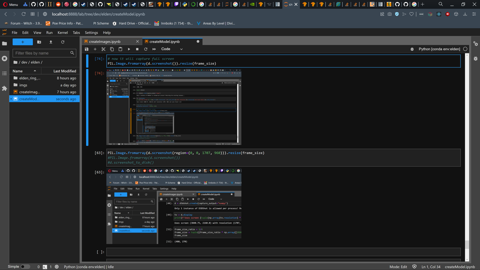

In [75]:
# now it will capture full screen
PIL.Image.fromarray(d.screenshot()).resize(frame_size)

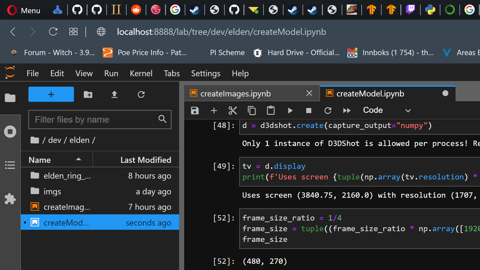

In [63]:
PIL.Image.fromarray(d.screenshot(region=(0, 0, 1707, 960))).resize(frame_size)
#PIL.Image.fromarray(d.screenshot())
#d.screenshot_to_disk()

In [ ]:
# Free sound effects source:
#   https://mixkit.co/free-sound-effects/
#
#  Attribution not required
# 
#   https://mixkit.co/terms/
#   https://mixkit.co/license/